# Preliminary

L'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

Il vous conseille dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).

## Imports 

In [53]:
import os
import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import missingno as msno
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import tarfile
import sklearn
import random


print(os.getcwd())
print("Numpy : {}".format(np.__version__))
print("Pandas : {}".format(pd.__version__))
print("Missingno Version : {}".format(msno.__version__))
print("Matplotlib Version : {}".format(matplotlib.__version__))
print("Seaborn Version : {}".format(sns.__version__))
print("Scikit-Learn Version : {}".format(sklearn.__version__))

C:\Users\Lemel\OPC-P6
Numpy : 1.23.5
Pandas : 1.5.3
Missingno Version : 0.4.2
Matplotlib Version : 3.7.0
Seaborn Version : 0.12.2
Scikit-Learn Version : 1.2.1


# Fonctions

In [34]:
def shape2(df):
    """
    Analyzes the shape of the dataframe: 1) Open it, give some infos 2) Nan values 3) Describe method
    """

    # Head & tail
    df_combined = pd.concat([df.head(), df.tail()], axis=0)
    display(df_combined)
    print("\nNumber of Rows: ", df.shape[0])
    print("Number of Columns: ", df.shape[1])

    for col in df.columns:
            print("Column {}: {}".format(col, df[col].dtype))

    for col in df.columns:
            print("\nUnique values in {}:".format(col))
            print(df[col].unique())

    # N_unique values
    nunique_dict = {col: df[col].nunique() for col in df.columns}
    nunique_df = pd.DataFrame.from_dict(nunique_dict, orient='index', columns=['N_unique values'])
    display(nunique_df)

    # Value counts and missing/duplicated data
    if 'type' in df.columns:
        print("\nValue counts of 'type':")
        print(df['type'].value_counts())
    else:
        print("\n'type' column not found in dataframe.")
    print("\nNumber of missing values:")
    print(df.isna().sum())
    print("\nNumber of duplicated rows:")
    print(df.duplicated().sum())

    # Seaborn heatmap
    print("\nSeaborn heatmap:")
    sns.heatmap(df.isnull(), cmap='viridis')
    plt.show()

In [35]:
def shape3(df):
    """
    Analyzes the shape of the dataframe: 1) Open it, give some infos 2) Nan values 3) Describe method
    """

    # Head & tail
    df_combined = pd.concat([df.head(), df.tail()], axis=0)
    display(df_combined)
    print("\nNumber of Rows: ", df.shape[0])
    print("Number of Columns: ", df.shape[1])

    for col in df.columns:
            print("Column {}: {}".format(col, df[col].dtype))

    for col in df.columns:
        if col == '_Tags':
            print("\nUnique values in {}:".format(col))
            unique_tags = set(tag for tag_list in df[col] for tag in tag_list)
            print(unique_tags)
        else:
            print("\nUnique values in {}:".format(col))
            print(df[col].unique())

    # N_unique values
    nunique_dict = {}
    for col in df.columns:
        if col == '_Tags':
            nunique_dict[col] = len(set(tag for tag_list in df[col] for tag in tag_list))
        else:
            nunique_dict[col] = df[col].nunique()

    nunique_df = pd.DataFrame.from_dict(nunique_dict, orient='index', columns=['N_unique values'])
    display(nunique_df)

    # Value counts and missing/duplicated data
    if 'type' in df.columns:
        print("\nValue counts of 'type':")
        print(df['type'].value_counts())
    else:
        print("\n'type' column not found in dataframe.")
    print("\nNumber of missing values:")
    print(df.isna().sum())

    # Check duplicates with _Tags as strings
    df_temp = df.copy()
    df_temp['_Tags'] = df_temp['_Tags'].apply(lambda x: str(x))
    print("\nNumber of duplicated rows:")
    print(df_temp.duplicated().sum())

    # Seaborn heatmap
    print("\nSeaborn heatmap:")
    sns.heatmap(df.isnull(), cmap='viridis')
    plt.show()

# Ouverture du dataset

In [36]:
# Data acces

path = "C:\\Users\\Lemel\\OPC-P6"
tar_path = "C:\\Users\\Lemel\\OPC-P6\\images.tar"
extract_path = "C:\\Users\\Lemel\\OPC-P6\\images"

# tarfile.open() to open the file
with tarfile.open(tar_path) as tar:
    # extract the contents of the tar file
    tar.extractall(path=extract_path)
    # Get the list of files in the tar file
    files = tar.getnames()

# Print the number of files
print("Number of files:", len(files))

Number of files: 20701


In [39]:
# Data acces
images_dir = os.path.join(extract_path, "Images")

# Get a list of all the breed directories
breeds = os.listdir(images_dir)

# Initialize a list 
data = []

# Loop over each breed
for breed in breeds:
    # Get a list of all the images for this breed
    images = os.listdir(os.path.join(images_dir, breed))
    # Append the breed and the number of images to the data list
    data.append([breed, len(images)])

# Convert the data list to a DataFrame
df = pd.DataFrame(data, columns=['Breed', 'Number of Images'])

# Print the total number of breeds
print("Total number of breeds:", len(breeds))

Total number of breeds: 120


In [47]:
# Représentartion rapide
df.head()

,Breed,Number of Images
0,n02085620-Chihuahua,152
1,n02085782-Japanese_spaniel,185
2,n02085936-Maltese_dog,252
3,n02086079-Pekinese,149
4,n02086240-Shih-Tzu,214


,Breed,Number of Images
0,n02085620-Chihuahua,152
1,n02085782-Japanese_spaniel,185
2,n02085936-Maltese_dog,252
3,n02086079-Pekinese,149
4,n02086240-Shih-Tzu,214
115,n02113799-standard_poodle,159
116,n02113978-Mexican_hairless,155
117,n02115641-dingo,156
118,n02115913-dhole,150
119,n02116738-African_hunting_dog,169



Number of Rows:  120
Number of Columns:  2
Column Breed: object
Column Number of Images: int64

Unique values in Breed:
['n02085620-Chihuahua' 'n02085782-Japanese_spaniel'
 'n02085936-Maltese_dog' 'n02086079-Pekinese' 'n02086240-Shih-Tzu'
 'n02086646-Blenheim_spaniel' 'n02086910-papillon' 'n02087046-toy_terrier'
 'n02087394-Rhodesian_ridgeback' 'n02088094-Afghan_hound'
 'n02088238-basset' 'n02088364-beagle' 'n02088466-bloodhound'
 'n02088632-bluetick' 'n02089078-black-and-tan_coonhound'
 'n02089867-Walker_hound' 'n02089973-English_foxhound' 'n02090379-redbone'
 'n02090622-borzoi' 'n02090721-Irish_wolfhound'
 'n02091032-Italian_greyhound' 'n02091134-whippet'
 'n02091244-Ibizan_hound' 'n02091467-Norwegian_elkhound'
 'n02091635-otterhound' 'n02091831-Saluki' 'n02092002-Scottish_deerhound'
 'n02092339-Weimaraner' 'n02093256-Staffordshire_bullterrier'
 'n02093428-American_Staffordshire_terrier' 'n02093647-Bedlington_terrier'
 'n02093754-Border_terrier' 'n02093859-Kerry_blue_terrier'
 'n020

,N_unique values
Breed,120
Number of Images,49



'type' column not found in dataframe.

Number of missing values:
Breed               0
Number of Images    0
dtype: int64

Number of duplicated rows:
0

Seaborn heatmap:


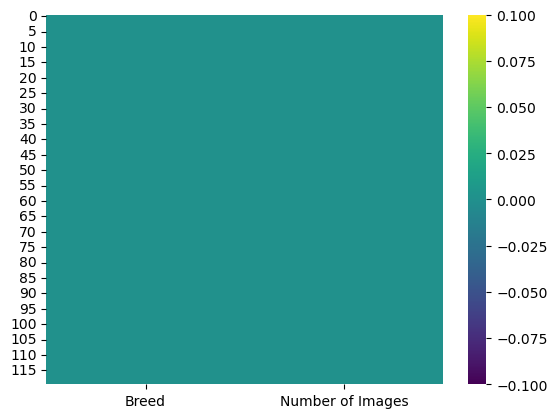

In [49]:
# Ici nous avons la liste de toutes les races 
shape2(df)

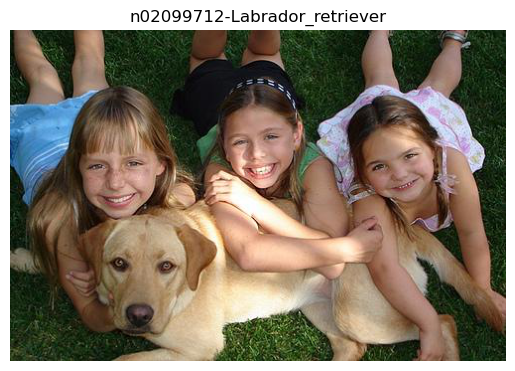

In [63]:
# Random example ; each time.
random_breed = random.choice(breeds)

# Get a list of all images for this 'breed example'
images = os.listdir(os.path.join(images_dir, random_breed))

# Choose a random image from this 'breed example'
random_image = random.choice(images)

# Create the full path to the image example
example_image_path = os.path.join(images_dir, random_breed, random_image)

# Load the image
img = mpimg.imread(example_image_path)

# Display the image
plt.imshow(img)
plt.title(random_breed)
plt.axis('off')  # to hide the axis
plt.show()

# Pictures Pre-processing
**Il vous conseille dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).**

## Cropping

## Whitening

In [136]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the directory where the images are
images_dir = os.path.join(extract_path, "Images")

#  
batch_size = 32
img_height = 180
img_width = 180

# Initialize the ImageDataGenerator for whitening 
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation de la valeur des pixels, 
    validation_split=0.2,  # use 20% of the data for validation
    zca_whitening=True)  # apply ZCA whitening

# Load and iterate training dataset
train_it = datagen.flow_from_directory(images_dir, 
                                       target_size=(img_height, img_width), 
                                       color_mode='rgb', 
                                       class_mode='categorical', 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       subset='training')

# Load and iterate validation dataset
val_it = datagen.flow_from_directory(images_dir, 
                                     target_size=(img_height, img_width), 
                                     color_mode='rgb', 
                                     class_mode='categorical', 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     subset='validation')

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


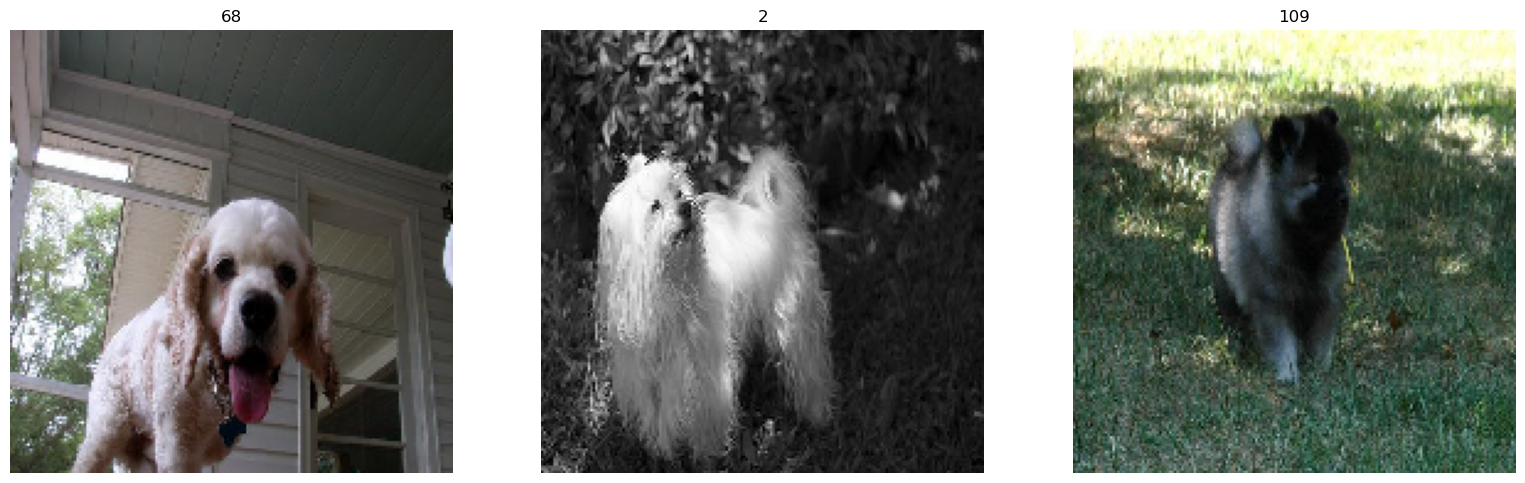

In [139]:
# Get one batch of images
images, labels = next(train_it)
plt.figure(figsize=(40, 10))


# Display the first 3 images
for i in range(3):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
    
plt.show()